In [1]:
import os
import cv2
import random
import numpy as np
from collections import Counter
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, StratifiedKFold
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Activation, Flatten, Dropout, BatchNormalization, Conv2D, AveragePooling2D, Dense

Using TensorFlow backend.


In [2]:
# Goal: 60% train, 20% validate, 20% test -> 80% train+validate, 20% test
# Each patient must have all their lesions be in one set or the other, so we can't use train_test_split
# 318 total lesions -> 64*3=192=train, 64=validate, 62=test -> 256=train+validate, 62=test

folders = sorted(os.listdir("data_organized"))
train_val_patients = []
test_patients = []
test_count = 0
random.shuffle(folders)

for name in folders:
    train_val_patients.append(name)
    
for name in folders:
    _, count = name.split('+')
    # Fill up test_patients with 62 first
    count = int(count)
    if test_count+count <= 62:
        test_patients.append(name)
        test_count += count
        train_val_patients.remove(name)
        if test_count == 62:
            break
    elif test_count+count > 62:
        continue
        
print(test_count)

62


In [3]:
# Read in files from folders, store as np arrays of images (X_train) and clinsig labels (y_train)
# clinsig TRUE = 1, FALSE = 0
X = []
y = []

for folder in train_val_patients:
    for filename in sorted(os.listdir("data_organized/{}".format(folder))):
        root, _ = os.path.splitext(filename)
        patient, fid, adc_t2, size, zone, label = root.split('+')
        if adc_t2 == 'adc':
            if label == 'TRUE':
                y.append(1)
            else:
                y.append(0)
        img = Image.open("data_organized/{}/{}".format(folder, filename))
        img = img.resize((32, 32))
        array_gray = np.asarray(img)
        array = cv2.merge((array_gray,array_gray,array_gray))    
#         print(array.shape)
#         plt.imshow(array, cmap='gray')
#         plt.show()
        if adc_t2 == 'adc':
            X.append(array)

X = np.array(X)
y = np.array(y)

num, d1, d2, channels = X.shape
X = X.reshape(len(X), d1*d2*channels)

# Random over-sampling to remedy imbalanced dataset
print('Original: indolent={}, clinsig={}'.format(Counter(y)[0], Counter(y)[1]))
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print('Resampled: indolent={}, clinsig={}'.format(Counter(y_res)[0], Counter(y_res)[1]))
print('Flattened: X_res.shape={}, y_res.shape={}'.format(X_res.shape, y_res.shape))

X = X_res[:]
y = y_res[:]

X = X.reshape((3,32,32,X_res.shape[0])).transpose()
print('Unflattened: X.shape={}, y.shape={}'.format(X.shape, y.shape))

Original: indolent=191, clinsig=65
Resampled: indolent=191, clinsig=191
Flattened: X_res.shape=(382, 3072), y_res.shape=(382,)
Unflattened: X.shape=(382, 32, 32, 3), y.shape=(382,)


In [4]:
X, y = shuffle(X, y)

# Now split this into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=2)

#get the length of the train and validation data
ntrain = len(X_train)
nval = len(X_val)
print("ntrain={}, nval={}".format(ntrain, nval))

ntrain=286, nval=96


In [5]:
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(32,32,3))
# conv_base.summary()

In [13]:
chanDim = 3

model = tf.keras.Sequential()
model.add(conv_base)

model.add(Conv2D(32, (3, 3), padding="same")) # kernel_initializer=init ? 
model.add(BatchNormalization(axis=chanDim))
model.add(Activation("relu"))

for i in range(9):
    model.add(Conv2D(32, (3, 3), padding="same")) 
    model.add(BatchNormalization(axis=chanDim))
    model.add(Activation("relu"))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(BatchNormalization(axis=chanDim))
    
model.add(AveragePooling2D(pool_size=(3, 3), padding="same"))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid')) #Sigmoid function at the end because we have just two classes

# model.add(conv_base)
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

# model.summary()

In [14]:
print('Number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('Number of trainable weights after freezing the conv base:', len(model.trainable_weights))

# binary_crossentropy loss because its a binary classification
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(lr=1e-5), metrics=['acc'])

Number of trainable weights before freezing the conv base: 80
Number of trainable weights after freezing the conv base: 80


In [15]:
batch_size = 64

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    shear_range=0.2,
                    zoom_range=[0.7,1],
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

np.asarray(y_train).astype('float32').reshape((-1,1))
np.asarray(y_val).astype('float32').reshape((-1,1))

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [16]:
history = model.fit(train_generator,
                    steps_per_epoch=ntrain//batch_size,
                    epochs=170,
                    validation_data=val_generator,
                    validation_steps=nval//batch_size)

Epoch 1/170
4/4 [==============================] - 2s 472ms/step - acc: 0.5315 - loss: 0.6955 - val_loss: 0.6931 - val_acc: 0.5469
Epoch 2/170
4/4 [==============================] - 0s 105ms/step - acc: 0.4955 - loss: 0.6986 - val_loss: 0.6932 - val_acc: 0.4062
Epoch 3/170
4/4 [==============================] - 0s 111ms/step - acc: 0.4955 - loss: 0.7053 - val_loss: 0.6932 - val_acc: 0.4375
Epoch 4/170
4/4 [==============================] - 0s 119ms/step - acc: 0.5180 - loss: 0.7056 - val_loss: 0.6933 - val_acc: 0.4219
Epoch 5/170
4/4 [==============================] - 0s 109ms/step - acc: 0.5225 - loss: 0.6971 - val_loss: 0.6932 - val_acc: 0.4844
Epoch 6/170
4/4 [==============================] - 0s 115ms/step - acc: 0.5270 - loss: 0.6903 - val_loss: 0.6933 - val_acc: 0.4375
Epoch 7/170
4/4 [==============================] - 0s 118ms/step - acc: 0.5273 - loss: 0.6968 - val_loss: 0.6933 - val_acc: 0.4531
Epoch 8/170
4/4 [==============================] - 0s 120ms/step - acc: 0.4730 - lo

4/4 [==============================] - 0s 106ms/step - acc: 0.5360 - loss: 0.6874 - val_loss: 0.6947 - val_acc: 0.4688
Epoch 64/170
4/4 [==============================] - 0s 105ms/step - acc: 0.4648 - loss: 0.6982 - val_loss: 0.6941 - val_acc: 0.4844
Epoch 65/170
4/4 [==============================] - 0s 98ms/step - acc: 0.5405 - loss: 0.6859 - val_loss: 0.6963 - val_acc: 0.4375
Epoch 66/170
4/4 [==============================] - 0s 105ms/step - acc: 0.5045 - loss: 0.6935 - val_loss: 0.6971 - val_acc: 0.4219
Epoch 67/170
4/4 [==============================] - 0s 105ms/step - acc: 0.5312 - loss: 0.6881 - val_loss: 0.6987 - val_acc: 0.3906
Epoch 68/170
4/4 [==============================] - 0s 104ms/step - acc: 0.5721 - loss: 0.6839 - val_loss: 0.6982 - val_acc: 0.4062
Epoch 69/170
4/4 [==============================] - 0s 96ms/step - acc: 0.5360 - loss: 0.6956 - val_loss: 0.6976 - val_acc: 0.4219
Epoch 70/170
4/4 [==============================] - 0s 104ms/step - acc: 0.5547 - loss: 0.6

4/4 [==============================] - 1s 165ms/step - acc: 0.5315 - loss: 0.6908 - val_loss: 0.7010 - val_acc: 0.4219
Epoch 126/170
4/4 [==============================] - 1s 148ms/step - acc: 0.4910 - loss: 0.6940 - val_loss: 0.7019 - val_acc: 0.3906
Epoch 127/170
4/4 [==============================] - 1s 144ms/step - acc: 0.5586 - loss: 0.6864 - val_loss: 0.6888 - val_acc: 0.5156
Epoch 128/170
4/4 [==============================] - 1s 160ms/step - acc: 0.5625 - loss: 0.6799 - val_loss: 0.7035 - val_acc: 0.4062
Epoch 129/170
4/4 [==============================] - 1s 144ms/step - acc: 0.5315 - loss: 0.6869 - val_loss: 0.6966 - val_acc: 0.4844
Epoch 130/170
4/4 [==============================] - 1s 160ms/step - acc: 0.5273 - loss: 0.6902 - val_loss: 0.6942 - val_acc: 0.5000
Epoch 131/170
4/4 [==============================] - 1s 151ms/step - acc: 0.5180 - loss: 0.6951 - val_loss: 0.6990 - val_acc: 0.4531
Epoch 132/170
4/4 [==============================] - 1s 149ms/step - acc: 0.5541 - 

In [17]:
model.save_weights('models/model_adc_weights.h5')
model.save('models/model_adc_keras.h5')

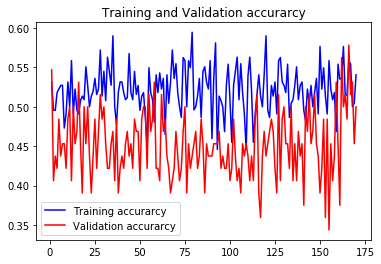

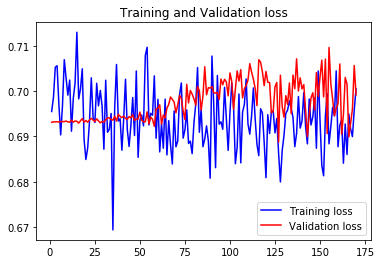

In [18]:
# Plot validation and losss

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

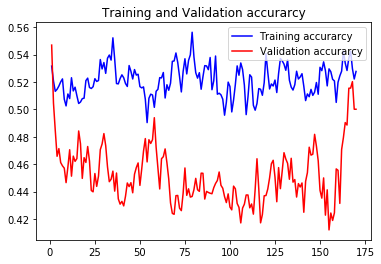

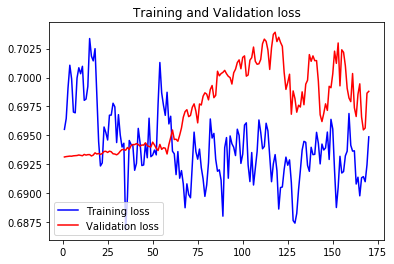

In [19]:
# Plot validation and losss with smoother lines

def smooth_plot(points, factor=0.7):
    smooth_pts = []
    for point in points:
        if smooth_pts:
            previous = smooth_pts[-1]
            smooth_pts.append(previous * factor + point * (1 - factor))
        else:
            smooth_pts.append(point)
    return smooth_pts

#Plot figure
plt.plot(epochs, smooth_plot(acc), 'b', label='Training accurarcy')
plt.plot(epochs, smooth_plot(val_acc), 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.show()

plt.plot(epochs, smooth_plot(loss), 'b', label='Training loss')
plt.plot(epochs, smooth_plot(val_loss), 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [20]:
#Prepare test set

X_test = []
y_test = []

for folder in test_patients:
    for filename in sorted(os.listdir("data_organized/{}".format(folder))):
        root, _ = os.path.splitext(filename)
        patient, fid, adc_t2, size, zone, label = root.split('+')
        if adc_t2 == 'adc':
            if label == 'TRUE':
                y_test.append(1)
            else:
                y_test.append(0)
        img = Image.open("data_organized/{}/{}".format(folder, filename))
        img = img.resize((32, 32))
        array_gray = np.asarray(img)
        array = cv2.merge((array_gray,array_gray,array_gray))  
        if adc_t2 == 'adc':
            X_test.append(array)

In [21]:
x = np.array(X_test)
y = np.array(y_test)
total = len(x)
test_datagen = ImageDataGenerator(rescale=1./255)

predictions = 0
correct = 0
false_pos = 0
false_neg = 0
i = 0
for batch in test_datagen.flow(x, batch_size=1):
    pred = model.predict(batch)
    prediction = 1 if pred > 0.5 else 0
    actual = 1 if y[i] == 1 else 0
    if prediction == actual:
        correct += 1
    else:
        if prediction == 1 and actual == 0:
            false_pos += 1
        else:
            false_neg += 1
    predictions += prediction
    i += 1
    if i == total:
        break
    
print('ACCURACY: {}%'.format(correct/total * 100))
print('FALSE POSITIVE: {}%'.format(false_pos/(total-correct)))
print('FALSE NEGATIVE: {}%'.format(false_neg/(total-correct)))
print('CLINICALLY SIGNIFICANT PREDICTION: {}%'.format(predictions/total))

ACCURACY: 69.35483870967742%
FALSE POSITIVE: 0.631578947368421%
FALSE NEGATIVE: 0.3684210526315789%
CLINICALLY SIGNIFICANT PREDICTION: 0.22580645161290322%
